<h1><center>DEEP LEARNING</center></h1>

Pembelajaran mendalam (deep learning) adalah jenis pembelajaran mesin (machine learning) yang dalam hal ini model belajar untuk melakukan tugas klasifikasi langsung dari gambar, teks, atau suara. Pembelajaran mendalam biasanya diimplementasikan menggunakan arsitektur jaringan saraf. Istilah “deep” (dalam) mengacu pada jumlah lapisan di dalam jaringan—semakin banyak lapisan, semakin dalam jaringan. Jaringan saraf tradisional hanya berisi 2 atau 3 lapisan, sedangkan jaringan dalam dapat memiliki ratusan lapisan. [Source](https://www.mathworks.com/help/deeplearning/ug/deep-learning-in-matlab.html)

---
**Algoritma yang terdapat dalam Deep Learning:**
1. Feed Forward Neural Network
2. Convolutional Neural Network
3. Recurrent Neural Network
4. Generative Adversial Network
5. Graph Neural Network
6. Graph Convolutional Neural Network
7. Transformer Neural Network
8. Etc

---
**Kelebihan Deep Learning:**
1. Akurasi sangat tinggi
2. Bisa diimplementasikan pada banyak kasus

---
**Kekurangan Deep Learning:**
1. Data masukan harus dilabeli terlebih dahulu
2. Biaya komputasi yang mahal
3. Pembelajaran model AI bisa menghabiskan waktu
yang lama

---
![deeplearning](https://github.com/user-attachments/assets/3194d60c-25f8-4db5-b256-81b7a581c8e7)

<h2><b>Import Library</b></h2>

In [1]:
import numpy as np 
import pandas as pd 
import kagglehub
import random
from os import listdir

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import cv2 as cv
from PIL import Image
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms.functional import to_pil_image

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

<h2><b>Download Dataset</b></h2>

<h4>Studi Kasus</h4>

Dataset ini berisi tentang berbagai hewan reptile dan amphibi yang diambil dari pixabay.com dan flickr.com. Terdapat 10 class dalam dataset ini, yaitu: 
1. Chameleon
2. Crocodile_Alligator
3. Frog
4. Gecko
5. Iguana
6. Lizard
7. Salamander
8. Snake
9. Toad
10. Turle_Tortoise

Sumber dataset bisa diunduh dari link berikut: [Source](https://www.kaggle.com/datasets/vencerlanz09/reptiles-and-amphibians-image-dataset)

In [ ]:
path = kagglehub.dataset_download("vencerlanz09/reptiles-and-amphibians-image-dataset")
print("Path to dataset files:", path)

<h2><b>Load Data</b></h2>

In [2]:
data = []
folder='/kaggle/input/reptiles-and-amphibians-image-dataset'

for root, dirs, files in os.walk(folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')):
            label = os.path.basename(root)
            filepath = os.path.join(root, file)
            data.append((filepath, label))

image_df = pd.DataFrame(data, columns=["Filepath", "Label"])
image_df.head(5)

,Filepath,Label
0,/kaggle/input/reptiles-and-amphibians-image-da...,Chameleon
1,/kaggle/input/reptiles-and-amphibians-image-da...,Chameleon
2,/kaggle/input/reptiles-and-amphibians-image-da...,Chameleon
3,/kaggle/input/reptiles-and-amphibians-image-da...,Chameleon
4,/kaggle/input/reptiles-and-amphibians-image-da...,Chameleon


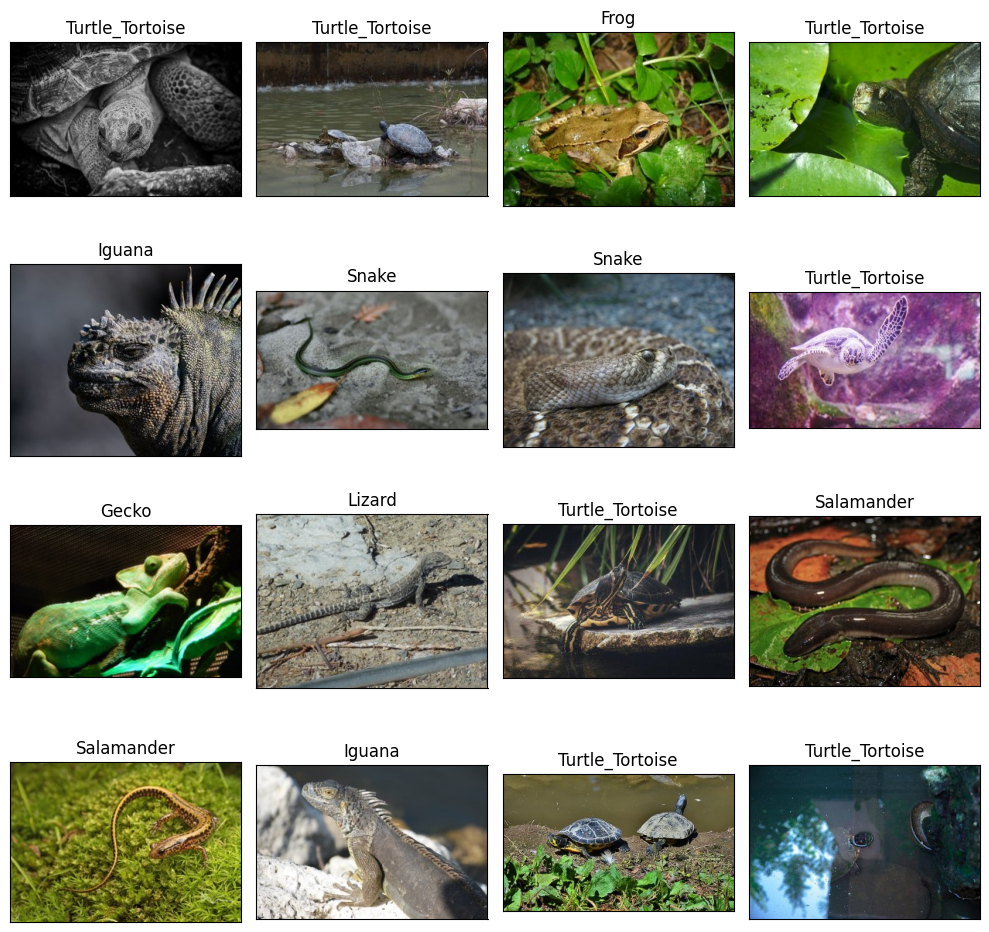

In [3]:
random_indices = random.sample(range(len(image_df)), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = imread(image_df.Filepath[random_indices[i]])
    ax.imshow(img)
    ax.set_title(image_df.Label[random_indices[i]])

plt.tight_layout()
plt.show()

<h2><b>Data Preprocessing</b></h2>

In [4]:
class getImageLabel(Dataset):
    def __init__(self, folder='/kaggle/input/reptiles-and-amphibians-image-dataset'):
        self.dataset = []

        to_one_hot = np.eye(10) 
        for i, rep in enumerate(sorted(listdir(folder))):
            for image_name in listdir(folder + "/" + rep):
                image = cv.resize(cv.imread(folder + "/" + rep + "/" + image_name), (224, 224)) / 255
                self.dataset.append([image, to_one_hot[i]])

    def __getitem__(self, item):
        feature, label = self.dataset[item]
        label_index = torch.argmax(torch.tensor(label, dtype=torch.float32))
        return torch.tensor(feature, dtype=torch.float32), label_index

    def __len__(self):
        return len(self.dataset)

Dalam function code diatas dilakukan resize dan normalisasi pada gambar. Resize dilakukan untuk melakukan standarisasi input, efisiensi dalam hal komputasi, dan menyesuaikan dengan arsitektur model. Model-model Deep Learning seperti MobileNet, ShuffleNet, dll membutuhkan input dengan dimensi yang tetap sehingga model dapat memprosesnya. Lalu jika melakukan pengecilan pixel dalam gambar (jika gambar berukuran besar), maka dapat mengurangi beban kerja memory dan waktu.

Lalu normalisasi yang dilakukan dalam kode diatas yaitu setiap nilai piksel gambar dibagi dengan 255 untuk mengubahnya dari rentang [0,255][0,255] menjadi [0,1][0,1]. Hal ini dilakukan supaya meningkatkan stabilitas karena dengan melakukan normalisasi dapat membantu skala nilai agar lebih seragam dan lebih kecil

<h2><b>Training</b></h2>

In [5]:
BATCH_SIZE = 32
EPOCH = 10
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Pada kode diatas kita akan menentukan jumlah batch size dan learning rate. Batch size adalah jumlah sampel (data) yang diproses sekaligus sebelum melakukan pembaruan bobot dalam model selama proses pelatihan. Sebagai contoh, disini kita mempunyai data sebanyak 6045 gambar dan kita set batch size menjadi 32. Maka akan terdapat sekitar **188 iterasi** dalam 1 epochnya. Hal ini dikarenakan rumus menghitung iterasi per epoch yaitu:

$$\text{Jumlah Iterasi per Epoch} = \lceil \frac{\text{Jumlah Data}}{\text{Batch Size}} \rceil$$

---

Ada 2 cara menentukan batch size:
1. **Eksperimen**
2. **Prinsip Scaling (Linear Scaling Rule)**
    - Jika memperbesar batch size (b), maka learning rate (n) juga seharusnya dinaikan secara linear.
      $$\eta_{\text{baru}} = \eta \times \frac{B_{\text{baru}}}{B_{\text{lama}}}$$
    - Contoh : jika awalnya batch size 32 dan learning rate 0.001 dan akan menaikan batch size ke 64, maka learning rate akan berubah menjadi 0.002
![](https://blog.paperspace.com/content/images/2022/07/over_ideal_under_fitting-1.png)

---
| **Batch Size**      | **Karakteristik**                                                      | **Kelebihan**                           | **Kekurangan**                                      |
|----------------------|------------------------------------------------------------------------|-----------------------------------------|----------------------------------------------------|
| **Bagus**   | Stabil, cukup efisien, sering digunakan pada banyak model.            | Stabil dan cepat.                       | Membutuhkan penyesuaian terhadap memori yang tersedia. |
| **Terlalu Rendah**   | Gradien noisy, pelatihan lambat.                                      | Lebih mungkin keluar dari *local minima*. | Tidak efisien, fluktuasi terlalu besar.            |
| **Terlalu Tinggi**   | Gradien stabil tetapi kurang variasi. Membutuhkan memori besar.       | Gradien sangat stabil.                  | Potensi terjebak di *local minima*, memori berat.   |

---

Learning rate salah satu hyperparameter yang menentukan seberapa besar langkah yang diambil oleh model selama proses pelatihan untuk memperbarui bobot berdasarkan gradien dari fungsi loss. Cara kerja learning rate adalah:
$$w_baru = w_lama - η ⋅ ∇L(w)$$
dimana
- w adalah bobot model
- ∇L(w) adalah gradien fungsi loss terhadap w
- η adalah learning rate

---

Ada 3 cara yang mungkin bisa digunakan dalam penentuan learning rate yaitu:
1. **Metode Learning Rate Range Test**
   - Metode ini diperkenalkan dalam makalah *Cyclical Learning Rates for Training Neural Networks* (2017) oleh Leslie N. Smith, yang bisa dimulai dengan learning rate kecil, lalu tingkatkan learning rate secara eksponensial setiap iterasi/batch. Learning rate optimal adalah tepat sebelum loss mulai meningkat tajam
2. **Rumus Teoritis (Learning Rate untuk SGD):**
     $$\eta = \frac{1}{\sqrt{n}}$$
     dimana
   - η adalah learning rate
   - n adalah ukuran dataset (jumlah sampel)
3. **Nilai Default Berdasarkan Optimizer**
   - SGD: 0.01 hingga 0.1
   - Adam: 0.001
   - AdaGrad / RMSProp: 0001 hingga 0.01
  
![](https://miro.medium.com/v2/resize:fit:459/0*C5kIkoBwht0fXRgs.jpeg)

In [6]:
dataset = getImageLabel(folder='/kaggle/input/reptiles-and-amphibians-image-dataset')

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

<h3><b>Convolutional Neural Network</b></h3>

<h5>Model 1</h5>

Convolutional Neural Network (CNN atau ConvNet) adalah algoritma pembelajaran mendalam yang populer, umumnya digunakan untuk memproses data yang memiliki topologi seperti grid. CNN merupakan arsitektur jaringan untuk pembelajaran mendalam yang belajar
langsung dari data, dengan menghilangkan kebutuhan untuk melakukan ekstraksi fitur secara manual. CNN terdiri dari 3 lapisan utama:
1. Convolutional Layer (+ReLU)
2. Pooling Layer
3. Fully-Connected Layer
[Source](https://informatika.stei.itb.ac.id/~rinaldi.munir/Citra/2024-2025/21-CNN-2024.pdf)
![cnn](https://github.com/user-attachments/assets/939b6efb-9d4c-4cb6-a6f1-0ed3e43d95e1)

---
Berikut merupakan gambaran model yang digunakan


![simplecnn](https://github.com/user-attachments/assets/c2ff82f8-bd68-4678-b793-b35383c33b00)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim=200, input_c=3, output=10, hidden_dim=128, dropout=0.5, device=DEVICE):
        super(SimpleCNN, self).__init__()

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=input_c, out_channels=20, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )
        self.fc = nn.Linear(in_features=50 * 23 * 23, out_features=output)

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.fc(torch.flatten(x, 1))
        return x

In [9]:
model = SimpleCNN(input_dim=200, input_c=3, output=10, hidden_dim=128, dropout=0.5, device=DEVICE)
model = model.to(DEVICE)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

<h5>Optimizer</h5>

Optimizer adalah algoritma atau metode yang digunakan untuk menyesuaikan bobot dan bias model neural network selama pelatihan agar meminimalkan fungsi loss. Berikut beberapa jenis-jenisnya :

1. Stochastic Gradient Descent (SGD)
2. SGD dengan Momentum
3. Adagrad (Adaptive Gradient Algorithm)
4. RMSprop (Root Mean Square Propagation)
5. Adam (Adaptive Moment Estimation)
6. AdaDelta

---

| **Optimizer**       | **Kelebihan**                                | **Kekurangan**                               | **Kegunaan untuk**                                         |
|----------------------|----------------------------------------------|---------------------------------------------|----------------------------------------------------------|
| **SGD**             | Sederhana dan efisien                       | Fluktuasi gradien, lambat                   | Model sederhana dan dataset besar                        |
| **Momentum**        | Lebih cepat konvergen, keluar dari jebakan local minima | Masih bergantung pada learning rate          | Model kompleks                                           |
| **Adagrad**         | Tidak perlu tuning learning rate             | Learning rate mengecil terlalu cepat        | NLP atau fitur jarang                                    |
| **RMSprop**         | Stabil untuk gradien bervariasi              | Memerlukan tuning learning rate             | RNN, LSTM                                                |
| **Adam**            | Cepat konvergen, otomatis adaptif            | Kadang tidak stabil di *local minima*       | Hampir semua deep learning, termasuk CNN dan RNN         |
| **AdaDelta**        | Tidak perlu learning rate manual             | Kurang populer                              | Model dengan gradien bervariasi                          |

---
<h5>Loss Function</h5>
Loss function adalah metrik yang digunakan untuk mengukur perbedaan antara prediksi model dan nilai sebenarnya (ground truth). Semakin mendekati 0 maka semakin bagus modelnya. Ada beberapa jenisnya seperti:

1. RMSE (Root Mean Squared Error)
2. MSE (Mean Squared Error)
3. MAE (Mean Absolute Error)
4. Cross-Entropy Loss

In [10]:
loss_train_all, loss_val_all = [], []

for epoch in range(EPOCH):
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for src, trg in train_loader:
        src = src.permute(0, 3, 1, 2).to(DEVICE)
        trg = trg.to(DEVICE)

        pred = model(src)
        loss = loss_function(pred, trg)
        train_loss += loss.detach().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for src, trg in val_loader:
            src = src.permute(0, 3, 1, 2).to(DEVICE)
            trg = trg.to(DEVICE)

            pred = model(src)
            loss = loss_function(pred, trg)
            val_loss += loss.detach().item()

    loss_train_all.append(train_loss / len(train_loader))
    loss_val_all.append(val_loss / len(val_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

Epoch 1, Train Loss: 2.0797316965303922, Validation Loss: 1.9569123818956573
Epoch 2, Train Loss: 1.9410784163869412, Validation Loss: 1.856973512419339
Epoch 3, Train Loss: 1.7839004581135915, Validation Loss: 1.8213804878037552
Epoch 4, Train Loss: 1.6316850597697092, Validation Loss: 1.880320639445864
Epoch 5, Train Loss: 1.4031523878413035, Validation Loss: 1.9194299845859921
Epoch 6, Train Loss: 1.1538587835498322, Validation Loss: 1.995058039139057
Epoch 7, Train Loss: 0.8341473995294786, Validation Loss: 2.292049325745681
Epoch 8, Train Loss: 0.5872056815857277, Validation Loss: 2.5756982852672707
Epoch 9, Train Loss: 0.3907797339939533, Validation Loss: 2.8871280571510054
Epoch 10, Train Loss: 0.2733142884602224, Validation Loss: 3.1666276043859023


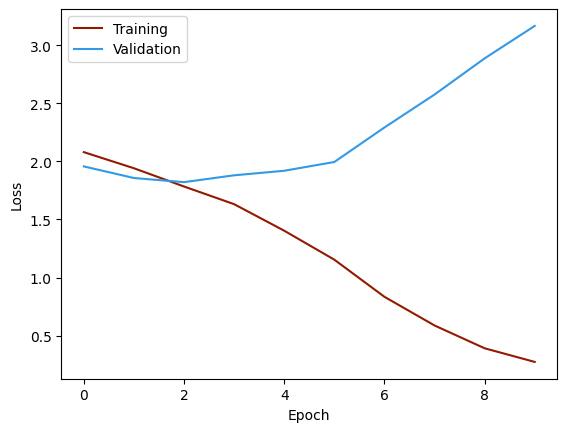

In [11]:
plt.plot(range(EPOCH), loss_train_all, color="#931a00", label='Training')
plt.plot(range(EPOCH), loss_val_all, color="#3399e6", label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
prediction, ground_truth = [], []
with torch.no_grad():
    model.eval()
    for batch, (src, trg) in enumerate(test_loader):
        src = src.permute(0, 3, 1, 2).to(DEVICE)
        trg = trg.to(DEVICE)

        pred = model(src)
        prediction.extend(torch.argmax(pred,dim=1).detach().cpu().numpy())
        ground_truth.extend(trg.detach().cpu().numpy())

classes = ('Chameleon', 'Crocodile_Alligator', 'Frog', 'Gecko', 'Iguana',
              'Lizard', 'Salamander', 'Snake', 'Toad', 'Turle_Tortoise')

In [13]:
print("accuracy score = ", accuracy_score(ground_truth, prediction))
print("precision score = ", precision_score(ground_truth, prediction, average='weighted'))
print("recall score = ", recall_score(ground_truth, prediction, average='weighted'))
print("f1 score score = ", f1_score(ground_truth, prediction, average='weighted'))  

accuracy score =  0.3513215859030837
precision score =  0.35580354916616214
recall score =  0.3513215859030837
f1 score score =  0.34864967845166367


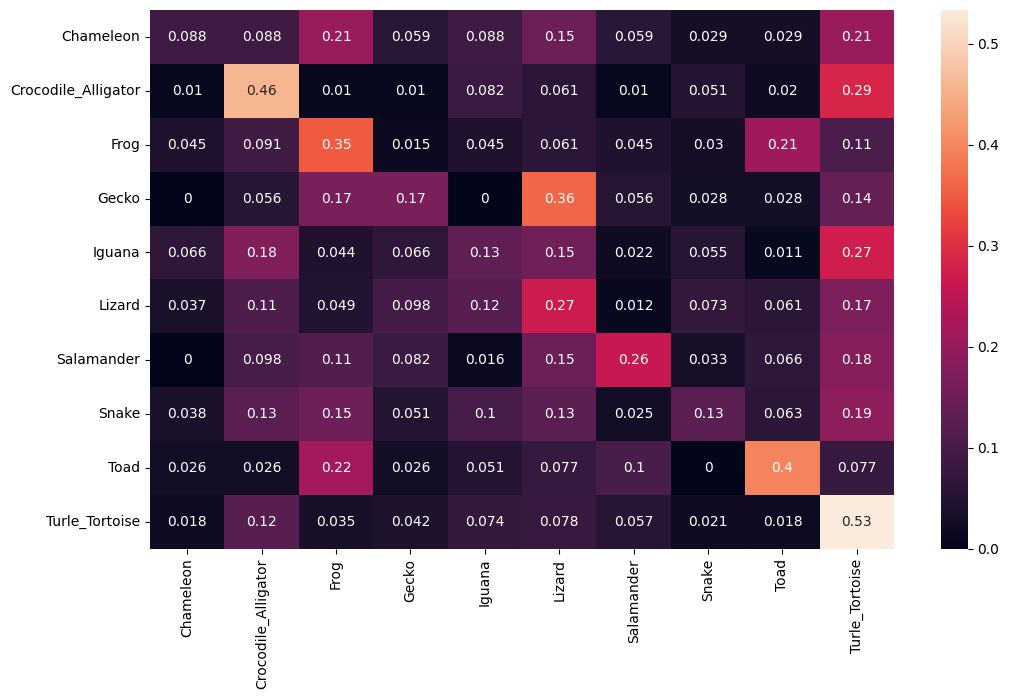

In [14]:
cf_matrix = confusion_matrix(ground_truth, prediction)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
                         columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True)
plt.show()

<h3><b>MobileNetV2</b></h3>

Disini kita menggunakan pre-trained model. Pre-trained mengacu pada model pembelajaran mesin atau jaringan neural yang telah dilatih sebelumnya pada dataset yang besar dan umum. Setelah dilatih, model ini memiliki weights atau bobot yang telah dioptimalkan untuk mengenali pola atau fitur umum dalam data tersebut. Keuntungan menggunakan pre trained model yaitu dapat menghemat waktu karena tidak perlu melatih model dari awal, dan hasilnya biasanya lebih akurat karena sudah dilatih menggunakan data yang besar. Contoh pre trained model yaitu ResNet, VGG, MobileNet, EfficientNet, dll. Disini kita menggunakan MobileNetV2

In [15]:
model2 = models.mobilenet_v2(pretrained=True)
num_classes = 10  
model2.classifier = nn.Sequential(
    nn.Linear(model2.last_channel, num_classes)
)

model2 = model2.to(DEVICE)

optimizer = Adam(model2.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]


In [16]:
loss_train2_all, loss_val2_all = [], []

for epoch in range(EPOCH):
    train2_loss = 0
    val2_loss = 0

    # Training loop
    model2.train()
    for src, trg in train_loader:
        src = src.permute(0, 3, 1, 2).to(DEVICE)
        trg = trg.to(DEVICE)

        pred = model2(src)
        loss = loss_function(pred, trg)
        train2_loss += loss.detach().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model2.eval()
    with torch.no_grad():
        for src, trg in val_loader:
            src = src.permute(0, 3, 1, 2).to(DEVICE)
            trg = trg.to(DEVICE)

            pred = model2(src)
            loss = loss_function(pred, trg)
            val2_loss += loss.detach().item()

    loss_train2_all.append(train2_loss / len(train_loader))
    loss_val2_all.append(val2_loss / len(val_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train2_loss / len(train_loader)}, Validation Loss: {val2_loss / len(val_loader)}")

Epoch 1, Train Loss: 1.1369078383409887, Validation Loss: 1.3969314201124783
Epoch 2, Train Loss: 0.7862947740052876, Validation Loss: 1.093947840148005
Epoch 3, Train Loss: 0.6953642094941964, Validation Loss: 0.9330887208724844
Epoch 4, Train Loss: 0.551161819270679, Validation Loss: 1.0449850076231464
Epoch 5, Train Loss: 0.4868477587413071, Validation Loss: 1.2416406088861927
Epoch 6, Train Loss: 0.44239230347531183, Validation Loss: 1.2843643652981724
Epoch 7, Train Loss: 0.3959818298095151, Validation Loss: 1.066511367929393
Epoch 8, Train Loss: 0.3224852009487331, Validation Loss: 1.2118501149374863
Epoch 9, Train Loss: 0.3392261201165673, Validation Loss: 1.1508155978959183
Epoch 10, Train Loss: 0.25099237090943005, Validation Loss: 1.1893320844091217


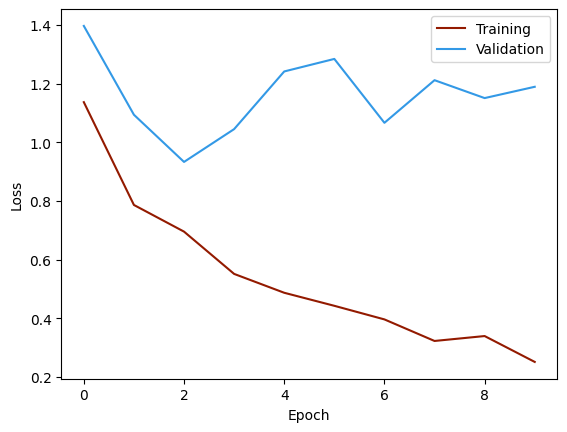

In [17]:
plt.plot(range(EPOCH), loss_train2_all, color="#931a00", label='Training')
plt.plot(range(EPOCH), loss_val2_all, color="#3399e6", label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
prediction_model2, ground_truth_model2 = [], []
with torch.no_grad():
    model2.eval()
    for batch, (src, trg) in enumerate(test_loader):
        src = src.permute(0, 3, 1, 2).to(DEVICE)
        trg = trg.to(DEVICE)

        pred = model2(src)
        prediction_model2.extend(torch.argmax(pred,dim=1).detach().cpu().numpy())
        ground_truth_model2.extend(trg.detach().cpu().numpy())

classes = ('Chameleon', 'Crocodile_Alligator', 'Frog', 'Gecko', 'Iguana',
              'Lizard', 'Salamander', 'Snake', 'Toad', 'Turle_Tortoise')

In [19]:
print("accuracy score = ", accuracy_score(ground_truth_model2, prediction_model2))
print("precision score = ", precision_score(ground_truth_model2, prediction_model2, average='weighted'))
print("recall score = ", recall_score(ground_truth_model2, prediction_model2, average='weighted'))
print("f1 score score = ", f1_score(ground_truth_model2, prediction_model2, average='weighted'))  

accuracy score =  0.7026431718061674
precision score =  0.7248053386709553
recall score =  0.7026431718061674
f1 score score =  0.6987848119619351


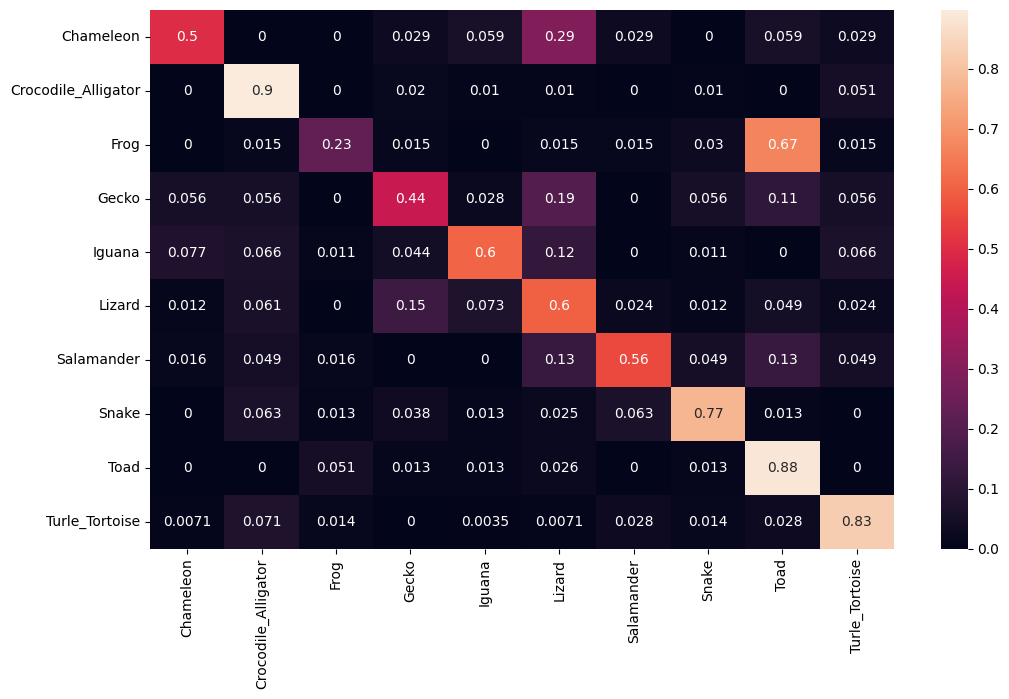

In [21]:
cf_matrix = confusion_matrix(ground_truth_model2, prediction_model2)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
                         columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True)
plt.show()